In [3]:
%load_ext autoreload
%autoreload 2

import sys; sys.path.append('..')
import pickle

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from genetic.utils import calculate_inertia, get_cluster_distribution

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
data = pd.read_csv('../data/clean_data/clean_data.csv')
data.head()

,duration_ms,loudness,tempo,valence,acousticness,danceability,energy
0,0.403695,0.451467,0.178779,0.963,0.732,0.819,0.341
1,0.483304,0.557378,0.412301,0.165,0.967,0.275,0.309
2,0.366304,0.530943,0.421576,0.253,0.957,0.418,0.193
3,0.983312,0.449265,0.529827,0.196,0.579,0.697,0.346
4,0.346890,0.514234,0.210284,0.406,0.996,0.518,0.203


# Preliminary logs

Disclaimer: I forgot to add to the logs the fitness (which is the inertia)...<br>
At least I've logged the best representations, so we can calculate the inertia and check!

In [6]:
with open('../data/logs/02-06-2024--00-54-17--ALGO_SELECTION.pkl', 'rb') as f:
    p_logs = pickle.load(f)

p_logs.keys()

dict_keys(['time', 'loop_time', 'best', 'selection', 'xo', 'mutation'])

In this preliminary run, we have ran 5 distinct populations for each combination of available Crossover, Selection and Mutation.<br>

In [7]:
df_pre = pd.DataFrame().from_dict(p_logs)
df_pre.head()

,time,loop_time,best,selection,xo,mutation
0,3.470610,"[0.2947573661804199, 0.30557823181152344, 0.26...","[[0.5144546499694906, 0.5144546499694906, 0.51...",tournament_sel,single_centroid_crossover,coordinate_mutation
1,4.519453,"[0.2886185646057129, 0.30994582176208496, 0.26...","[[0.36756888660184484, 0.14730487211706988, 0....",tournament_sel,single_centroid_crossover,coordinate_mutation
2,4.807515,"[0.30596256256103516, 0.31203770637512207, 0.2...","[[0.46964896500868103, 0.7433423008554427, 0.6...",tournament_sel,single_centroid_crossover,coordinate_mutation
3,5.567898,"[0.29167604446411133, 0.31197047233581543, 0.2...","[[0.6323033431528889, 0.6323033431528889, 0.63...",tournament_sel,single_centroid_crossover,coordinate_mutation
4,6.022527,"[0.30576229095458984, 0.3100917339324951, 0.26...","[[0.5560835084138883, 0.5560835084138883, 0.55...",tournament_sel,single_centroid_crossover,coordinate_mutation


In [8]:
df_pre.loc[:, 'inertia'] = df_pre.best.apply(lambda x: calculate_inertia(x, data))
df_pre.head()

,time,loop_time,best,selection,xo,mutation,inertia
0,3.470610,"[0.2947573661804199, 0.30557823181152344, 0.26...","[[0.5144546499694906, 0.5144546499694906, 0.51...",tournament_sel,single_centroid_crossover,coordinate_mutation,43935.198544
1,4.519453,"[0.2886185646057129, 0.30994582176208496, 0.26...","[[0.36756888660184484, 0.14730487211706988, 0....",tournament_sel,single_centroid_crossover,coordinate_mutation,37475.419456
2,4.807515,"[0.30596256256103516, 0.31203770637512207, 0.2...","[[0.46964896500868103, 0.7433423008554427, 0.6...",tournament_sel,single_centroid_crossover,coordinate_mutation,37954.473840
3,5.567898,"[0.29167604446411133, 0.31197047233581543, 0.2...","[[0.6323033431528889, 0.6323033431528889, 0.63...",tournament_sel,single_centroid_crossover,coordinate_mutation,46519.133218
4,6.022527,"[0.30576229095458984, 0.3100917339324951, 0.26...","[[0.5560835084138883, 0.5560835084138883, 0.55...",tournament_sel,single_centroid_crossover,coordinate_mutation,41792.266737


## Time of execution

<font color='red'>There were 18 batches of 5 populations, each batch with a different combination of selection, crossover and mutation algorithms. In total 84/85 runs were succesful.</font><br>
<br>
All the runs were made in parallel with a 13th Gen i9 CPU.<br>
The bottleneck was the **Crossover** step in PNN and pairwise algorithms. Due to its iterative nature of calculating new centroids and merging the closest ones, no parallelism could be implemented in this step.<br>
As the crossover algorithm was the most impactful parameter, we've decided to perform the bulk of this analysis taking it as the main actor.<br>
<br>
It is worth mentioning that we have coded an "early stopping" of sorts. And if, after 10 generations, the fitness didn't improve, the algorithm stops.

In [9]:
df_pre.loc[:, 'loop_time_mean'] = df_pre.loop_time.apply(lambda x: np.mean(x))
df_pre.loc[:, 'gens_to_converge'] = df_pre.loop_time.apply(lambda x: len(x) - 10)

In [10]:
round_mean = lambda x: int(np.mean(x))
round_mean.__name__ = 'mean'

df_pre.groupby(['xo'])[['time', 'loop_time_mean', 'gens_to_converge']].agg({'time': ['mean', 'std'], 'loop_time_mean': ['mean', 'std'], 'gens_to_converge': round_mean})

time            loop_time_mean            \
                                 mean        std           mean       std   
xo                                                                          
PNN                        352.776615  63.808783      22.735858  3.662518   
pairwise_crossover         106.016421  62.905720       4.387692  2.003210   
single_centroid_crossover    4.278971   1.230531       0.269855  0.005633   

                          gens_to_converge  
                                      mean  
xo                                          
PNN                                      5  
pairwise_crossover                      14  
single_centroid_crossover                5

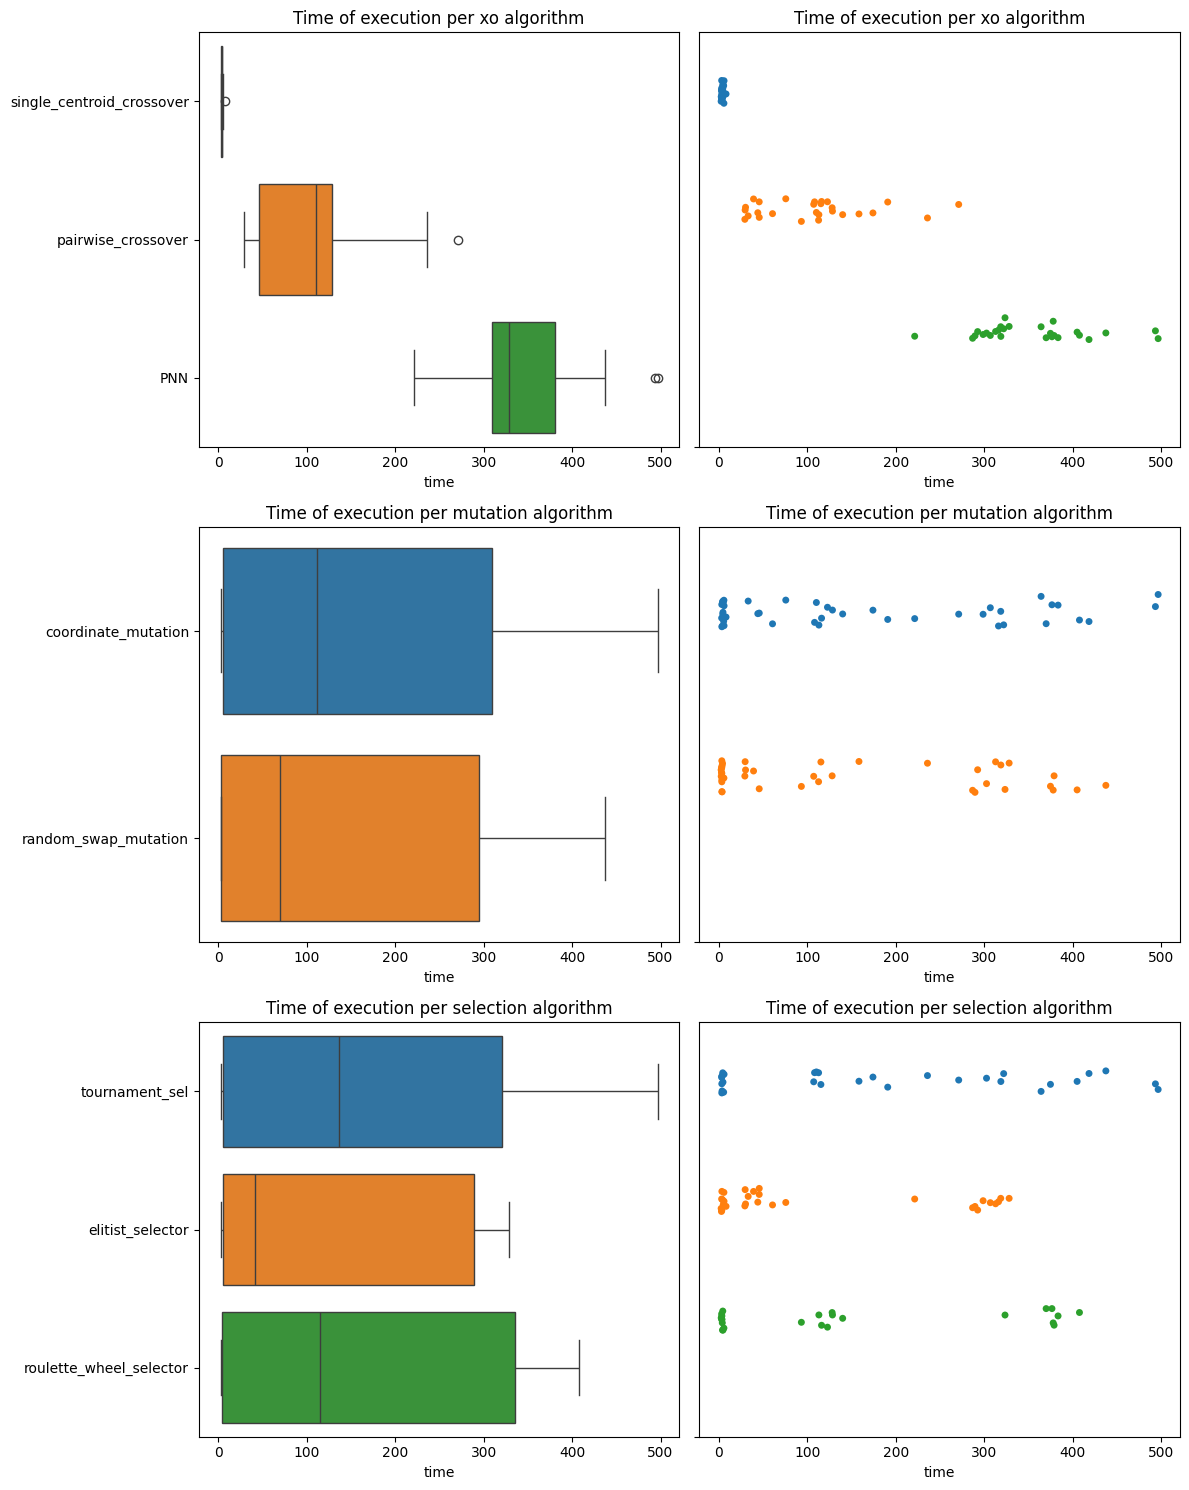

In [88]:
fig, axs = plt.subplots(3, 2, figsize=(12,15))
for algo, ax in zip(['xo', 'mutation', 'selection'], axs):
    sns.boxplot(df_pre, x='time', y=algo, ax=ax[0], hue=algo)
    sns.stripplot(df_pre, x='time', y=algo, ax=ax[1], hue=algo)
    
    ax[0].set_title(f'Time of execution per {algo} algorithm');
    ax[1].set_title(f'Time of execution per {algo} algorithm')

    ax[0].set_ylabel('')
    ax[1].set_ylabel('')

    ax[1].set_yticks('')

plt.tight_layout();

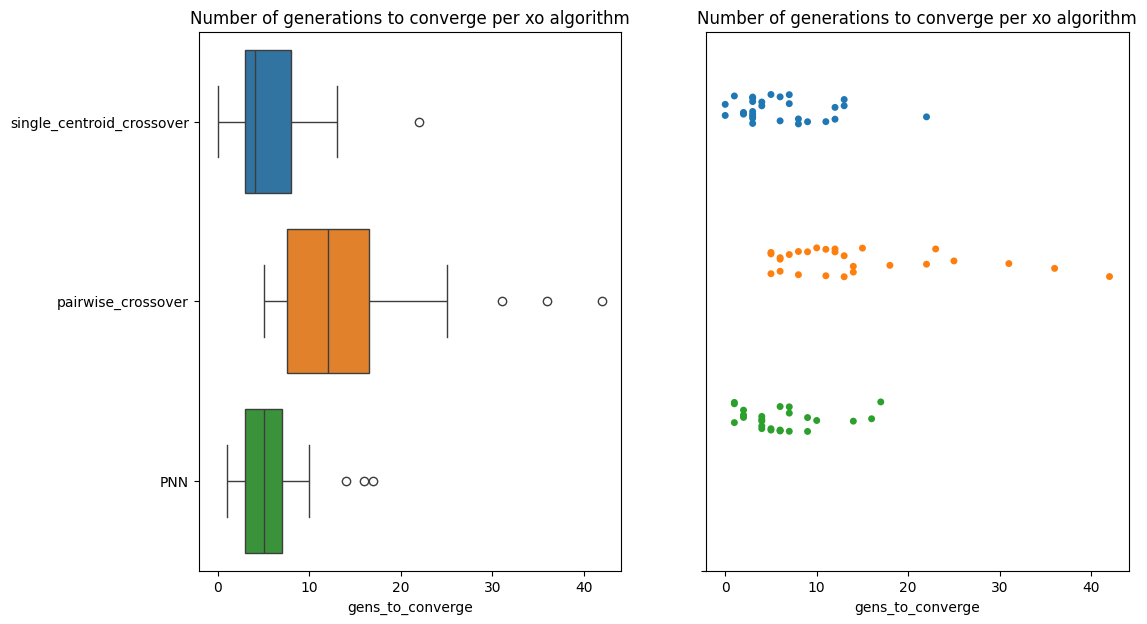

In [102]:
fig, axs = plt.subplots(1, 2, figsize=(12, 7))
sns.boxplot(df_pre, x='gens_to_converge', y='xo', ax=axs[0], hue='xo');
sns.stripplot(df_pre, x='gens_to_converge', y='xo', ax=axs[1], hue='xo')

axs[0].set_title('Number of generations to converge per xo algorithm')
axs[1].set_title('Number of generations to converge per xo algorithm')

axs[0].set_ylabel('')
axs[1].set_ylabel('')

axs[1].set_yticks('');

## Metrics

In [60]:
df_pre.groupby(['xo', 'selection', 'mutation'])[['inertia']].mean().sort_values('inertia')

inertia
xo                        selection               mutation                          
PNN                       roulette_wheel_selector random_swap_mutation  24628.276423
                                                  coordinate_mutation   24651.107880
                          tournament_sel          coordinate_mutation   27946.963038
                          elitist_selector        coordinate_mutation   28824.947380
                          tournament_sel          random_swap_mutation  29996.630264
                          elitist_selector        random_swap_mutation  31275.318396
pairwise_crossover        roulette_wheel_selector coordinate_mutation   32618.126185
                          tournament_sel          coordinate_mutation   34563.399489
                                                  random_swap_mutation  34778.850986
                          roulette_wheel_selector random_swap_mutation  36891.065124
single_centroid_crossover tournament_sel          coordinate_mutation   41535.298359
pairwise_crossover        elitist_selector        random_swap_mutation  41932.201667
single_centroid_crossover elitist_selector        coordinate_mutation   46524.588271
                          roulette_wheel_selector coordinate_mutation   48666.425775
pairwise_crossover        elitist_selector        coordinate_mutation   49760.273652
single_centroid_crossover tournament_sel          random_swap_mutation  50482.680424
                          roulette_wheel_selector random_swap_mutation  54451.409660
                          elitist_selector        random_swap_mutation  55391.328058

<font size=4 color='red'>ALL the best results were using PNN crossover.</font>

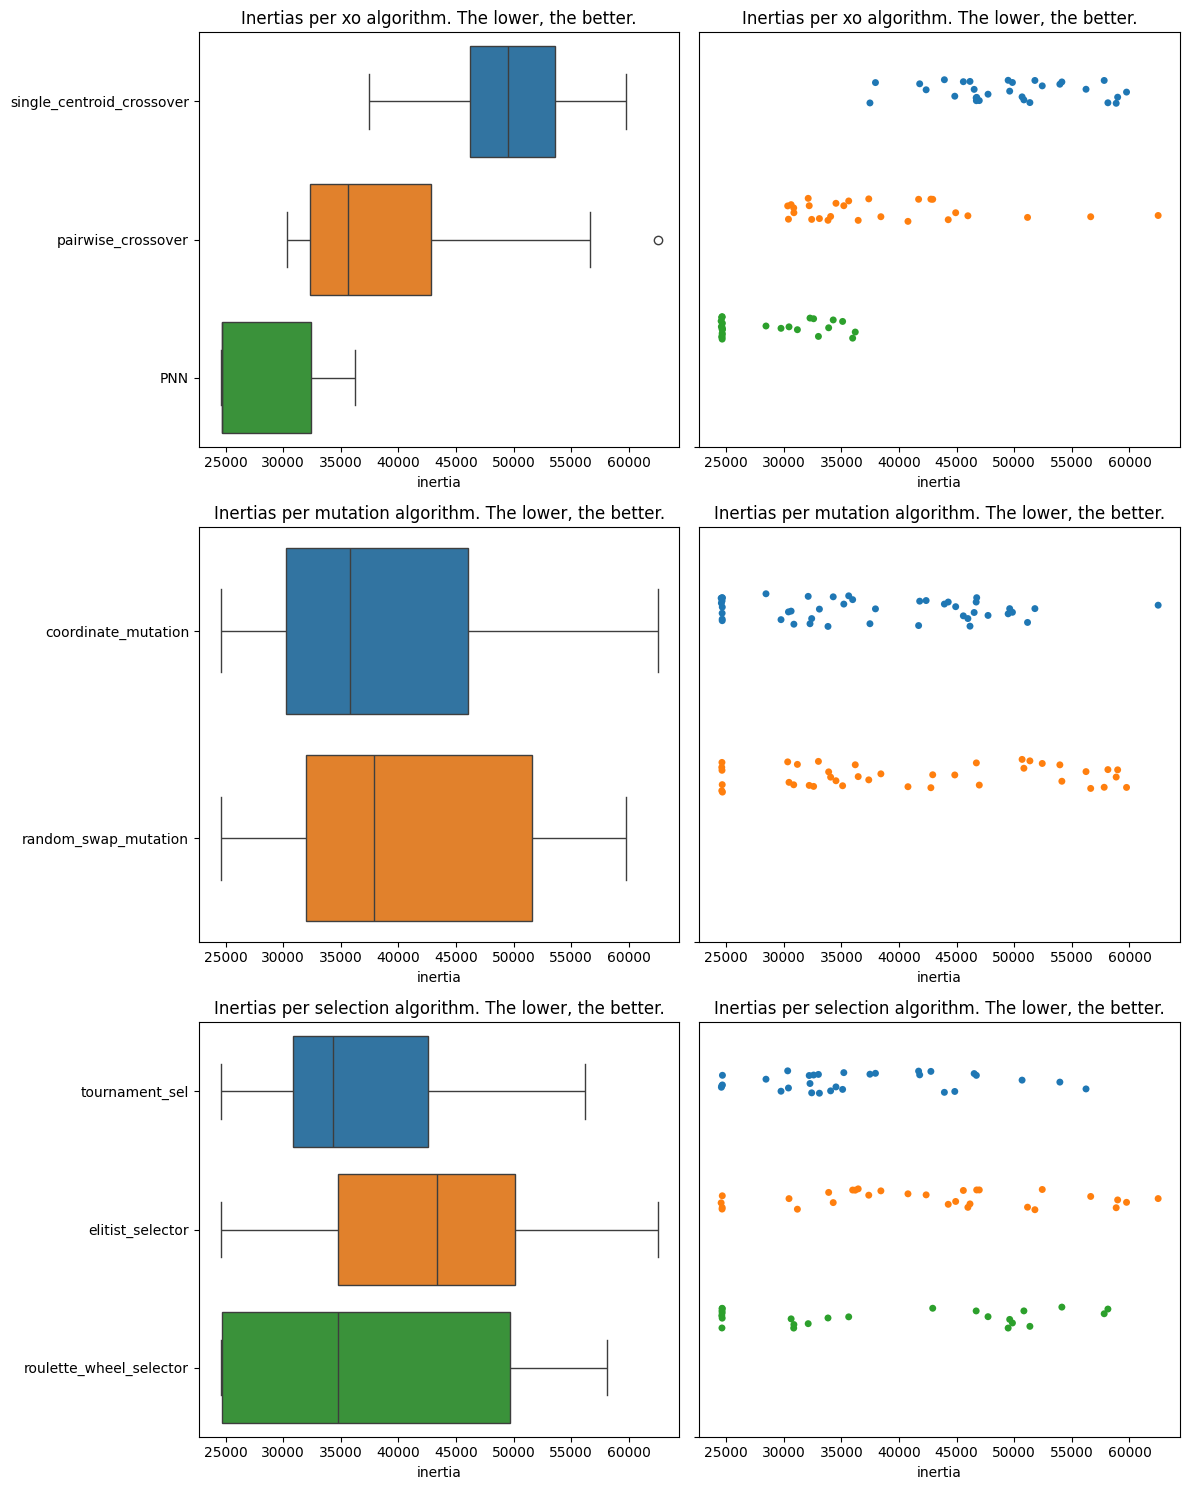

In [104]:
fig, axs = plt.subplots(3, 2, figsize=(12,15))
for algo, ax in zip(['xo', 'mutation', 'selection'], axs):
    sns.boxplot(df_pre, x='inertia', y=algo, ax=ax[0], hue=algo)
    sns.stripplot(df_pre, x='inertia', y=algo, ax=ax[1], hue=algo)
    
    ax[0].set_title(f'Inertias per {algo} algorithm. The lower, the better.');
    ax[1].set_title(f'Inertias per {algo} algorithm. The lower, the better.')

    ax[0].set_ylabel('')
    ax[1].set_ylabel('')

    ax[1].set_yticks('')

plt.tight_layout();

### Is PNN worth?

If the main aim is to get to the best value possible, using GAs, yes.<br>
If time is a constrain, let's try to greate a metric to measure it.

In [122]:
PNN_inertia = df_pre.loc[df_pre.xo == 'PNN', 'inertia']
PNN_time = df_pre.loc[df_pre.xo == 'PNN', 'time']

pairwise_inertia = df_pre.loc[df_pre.xo == 'pairwise_crossover', 'inertia']
pairwise_time = df_pre.loc[df_pre.xo == 'pairwise_crossover', 'time']

In [126]:
1 - (PNN_inertia.mean() / pairwise_inertia.mean())

0.2680666010667416

In [127]:
PNN_time.mean() / pairwise_time.mean()

3.3275657780992325

<font color='red'>The PNN improves the results in ~27%, but takes 3 times more to give a result, comparing to pairwise crossover.</font>

# Final logs with inertia as fitness

In [4]:
with open('../data/logs/02-06-2024--10:57:50--FULL_RUN.pkl', 'rb') as f:
    f_logs = pickle.load(f)

f_logs.keys()

dict_keys(['time', 'loop_time', 'best', 'selection', 'xo', 'mutation'])

In [5]:
df_final = pd.DataFrame().from_dict(f_logs)
df_final.head()

,time,loop_time,best,selection,xo,mutation
0,238.300086,"[25.65622878074646, 22.744904279708862, 18.439...","[[0.572482795589442, 0.616151106892431, 0.5589...",elitist_selector,PNN,random_swap_mutation
1,270.374340,"[24.326478719711304, 20.38233518600464, 25.697...","[[0.399085957885212, 0.4692869844803897, 0.519...",elitist_selector,PNN,random_swap_mutation
2,273.935669,"[22.499300241470337, 20.722336292266846, 25.70...","[[0.39449645693708185, 0.4698947680997421, 0.5...",elitist_selector,PNN,random_swap_mutation
3,349.308173,"[28.89338779449463, 21.612872838974, 24.201088...","[[0.5153669185295041, 0.5920158404245034, 0.53...",elitist_selector,PNN,random_swap_mutation
4,369.804610,"[25.507760286331177, 24.475112199783325, 16.53...","[[0.5096078375692251, 0.5995223796014387, 0.54...",elitist_selector,PNN,random_swap_mutation


In [71]:
df_final.loc[:, 'inertia'] = df_final.best.apply(lambda x: calculate_inertia(x, data))
df_final.head()

,time,loop_time,best,selection,xo,mutation,inertia
0,238.300086,"[25.65622878074646, 22.744904279708862, 18.439...","[[0.572482795589442, 0.616151106892431, 0.5589...",elitist_selector,PNN,random_swap_mutation,24594.332973
1,270.374340,"[24.326478719711304, 20.38233518600464, 25.697...","[[0.399085957885212, 0.4692869844803897, 0.519...",elitist_selector,PNN,random_swap_mutation,34687.608403
2,273.935669,"[22.499300241470337, 20.722336292266846, 25.70...","[[0.39449645693708185, 0.4698947680997421, 0.5...",elitist_selector,PNN,random_swap_mutation,24582.735565
3,349.308173,"[28.89338779449463, 21.612872838974, 24.201088...","[[0.5153669185295041, 0.5920158404245034, 0.53...",elitist_selector,PNN,random_swap_mutation,30109.687912
4,369.804610,"[25.507760286331177, 24.475112199783325, 16.53...","[[0.5096078375692251, 0.5995223796014387, 0.54...",elitist_selector,PNN,random_swap_mutation,24545.565633


## Time of execution

<font color='red'>There were 10 batches of 5 populations, totalling 50 independent runs.</font><br>
All the runs were made in parallel with a 13th Gen i9 CPU.<br>
The bottleneck was the **Crossover** step, most probably the application of Scikit-learn's KMeans. Its implementation allocates extra space in the memory and locks more than 1 thread. This could be observed by monitoring the CPU usage<br>
<br>
It is worth mentioning that we have coded an "early stopping" of sorts. And if, after 10 generations, the fitness didn't improve, the algorithm stops.

### Total time

In [17]:
mean_time_of_execution = df_final.time.mean()

In [20]:
print(f'Each batch of 5 population took, in average {mean_time_of_execution:.2f} seconds.')

Each batch of 5 population took, in average 324.25 seconds.


The parallel execution approach paid off. By running the population individually, each individual run was taking roughly 120 seconds to complete.

In [25]:
print(f'The improvement by running in parallel was {(mean_time_of_execution / (5*120))*100:.2f}%')

The improvement by running in parallel was 54.04%


In [27]:
print(f'The estimated total time of execution (for 50 runs) was: {mean_time_of_execution*10:.2f} seconds.')

The estimated total time of execution (for 50 runs) was: 3242.50 seconds.


### Loop time

In [42]:
loop_time_mean = df_final.loop_time.apply(lambda x: np.mean(x)).mean()

In [43]:
print(f'The mean time of execution of each generation loop was {loop_time_mean:.2f} seconds.')

The mean time of execution of each generation loop was 19.64 seconds.


In [50]:
loop_time_std = df_final.loop_time.apply(lambda x: np.std(x)).mean()

In [59]:
print(f'The standard deviation of time of execution of the generation loop was {loop_time_std:.2f} seconds.')

The standard deviation of time of execution of the generation loop was 6.30 seconds.


### Number of generations to converge

In [66]:
print(f'The algorithm took, in average, {df_final.loop_time.apply(lambda x: len(x) - 10).mean():.0f} generations to converge.')

The algorithm took, in average, 7 generations to converge.


## Metrics

### Best solution found

In [91]:
best = df_final[df_final.inertia == df_final.inertia.min()]
best_inertia = best.inertia.iloc[0]
best_centroids = best.best.iloc[0]
best_generations_to_converge = best.loop_time.apply(lambda x: len(x) - 10).iloc[0]

In [92]:
print(f'The best inertia was: {best_inertia:.2f}.')

The best inertia was: 24533.45.


In [93]:
print(f'The best run took {best_generations_to_converge} generations to converge.')

The best run took 6 generations to converge.


In [97]:
get_cluster_distribution(best_centroids, data)

labels
1    0.273422
2    0.260433
3    0.242361
0    0.223783
Name: proportion, dtype: float64

In [103]:
best_centroids

array([[0.56977874, 0.60622711, 0.55121396, 0.35920552, 0.12939079,
        0.51391685, 0.66755455],
       [0.51063327, 0.59817511, 0.53989838, 0.76862631, 0.16313677,
        0.65843156, 0.70148711],
       [0.40361735, 0.47195815, 0.52920241, 0.72225111, 0.76733847,
        0.60911294, 0.39902535],
       [0.48486117, 0.34432539, 0.44299391, 0.28710029, 0.86167361,
        0.41389669, 0.21086879]])

### Dispersion metrics

In [101]:
worst_inertia = df_final.inertia.max()
mean_inertia = df_final.inertia.mean()
std_inertia = df_final.inertia.std()

In [102]:
print(f'The worst result was: {worst_inertia:.2f}.')
print(f'The mean inertia was: {mean_inertia:.2f}.')
print(f'The inertia standard deviation was: {std_inertia:.2f}.')

The worst result was: 40909.98.
The mean inertia was: 28317.25.
The inertia standard deviation was: 4387.65.
